In [218]:
from pickling import load_pickle, create_pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
import choplo_statistique as cstats
import choplo_visualization as cvis
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import os
import statsmodels as sm
import pingouin as pg

In [12]:
a_df = load_pickle('amp')
a_side_df = load_pickle('side_amp')
a_jt_df = load_pickle('amp_jt_new_filt')
a_jt_full_df = load_pickle('amp_not_norm_joint_df_new_filt')
a_akl_full_df = load_pickle('amp_not_norm_ankle_df')
a_angle_full_df = load_pickle('amp_not_norm_angle_df')
a_st_df = load_pickle('amp_strat_new_filt')
a_missing_df = load_pickle('missing_amp')

v_df = load_pickle('vit')
v_side_df = load_pickle('side_vit')
v_jt_df = load_pickle('vit_jt_new_filt')
v_akl_full_df = load_pickle('vit_not_norm_ankle_df')
v_st_df = load_pickle('vit_strat_new_filt')
v_jt_full_df = load_pickle('vit_not_norm_joint_df_new_filt')
v_angle_full_df = load_pickle('vit_not_norm_angle_df')
v_missing_df = load_pickle('missing_vit') 


idx = pd.IndexSlice

C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\pandas\core\indexes\base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [3]:
val1, ind1 = ['value'], ['index']
val2, val3 = val1*2, val1*3
ind2, ind3 = ind1*2, ind1*3
v1, n1 = ['start_cm', 'rel_pt'], 'cm'
v2, n2 = ['amp_max_c7', 'amp_max_pel', 'amp_max_cop'], 'amp max'
v3, n3 = ['vel_max_c7', 'vel_max_pel', 'vel_max_cop'], 'vel max'
v4, n4 = ['dtml', 'dcm', 'rcm'], 'rcm'
v5, n5 = ['rel_pt', 'dcm'], 'cmmax vs dcm'
v6, n6 = ['dtml'], 'dtml'
v7, n7 = ['overshoot'], 'overshoot'

# v8, n8 = ['rcm'], 'rcm'

# WORKING WITH ANKLE BOS

In [145]:
#getting mean ankle pos for each move
a_ankle_l = a_akl_full_df.loc[:, idx[:,:,:,'ankle_l']].mean().groupby(level=[0,1]).mean()
a_ankle_l.name = 'value'

a_ankle_r = a_akl_full_df.loc[:, idx[:,:,:,'ankle_r']].mean().groupby(level=[0,1]).mean()
a_ankle_r.name = 'value'


#getting mean ankle pos for each move
v_ankle_l = v_akl_full_df.loc[:, idx[:,:,:,'ankle_l']].mean().groupby(level=[0,1]).mean()
v_ankle_l.name = 'value'

v_ankle_r = v_akl_full_df.loc[:, idx[:,:,:,'ankle_r']].mean().groupby(level=[0,1]).mean()
v_ankle_r.name = 'value'


In [247]:
df = v_ankle_l
df = df.reset_index()
df.replace(['lvl_0', 'lvl_1','lvl_2'],[0,1,2], inplace=True)
df.rename({'level_1':'subject'},axis=1,inplace = True)
df.rename({'level_0':'level'},axis=1,inplace = True)

aov_tbl = pg.rm_anova(df, dv='value', subject='subject',within='level', detailed=True, correction=True)
mc = pg.pairwise_ttests('value', within='level', subject='subject', data = df, padjust='fdr_bh', effsize='cohen')
w_sq = round(aov_tbl.iloc[0][8],3)
p_val = aov_tbl.iloc[0][6]

In [249]:
aov_tbl

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,w2,eps,sphericity,W-spher,p-spher
0,level,0.000165,2,0.000082,0.974004,0.396604,0.386432,0.0976542,-0.000552447,0.849438,True,inf,1
1,Error,0.001522,18,0.000085,-,-,-,-,-,-,-,-,-


# reset index

In [216]:
df = a_ankle_l
df = df.reset_index()
df.set_index('level_1', inplace = True)
df.replace(['lvl_0', 'lvl_1','lvl_2'],[0,1,2], inplace=True)
df.head()

,level_0,value
level_1,,
player_0,0,-0.017649
player_1,0,-0.000384
player_2,0,0.001527
player_3,0,-0.017368
player_4,0,-0.032389


In [217]:
data = df
results = ols("{} ~ C({})".format('value', 'level_0'), data=data).fit() 
mc = MultiComparison(data['value'], data['level_0'])
post_hoc = mc.
reject = post_hoc.reject
n_group = mc.ngroups
group1 = mc.pairindices[0]
group2 = mc.pairindices[1]
print(results.f_pvalue)

0.2797419362441815


level_1
player_0   -0.017649
player_1   -0.000384
player_2    0.001527
player_3   -0.017368
player_4   -0.032389
player_5   -0.011563
player_6   -0.011281
player_7   -0.034079
player_8   -0.000831
player_9   -0.000598
Name: value, dtype: float64

In [209]:
results.f_pvalue

0.7358028255349152

In [196]:
stats.f_oneway(data[data['level_0'] == 0]['value'], data[data['level_0'] == 1]['value'], data[data['level_0'] == 2]['value'])

F_onewayResult(statistic=1.3359270351928625, pvalue=0.279741936244182)

In [178]:
def box_plot_post_hoc_index(df, v:list, x='level', title=None, sharex=False, xlabel=None, ylabel=None,show=True,save=True, name='picture',dt='amplitude', get_fig=False, fig_size=(9.5, 6.5)):
    import matplotlib
    from matplotlib.ticker import FormatStrFormatter

    font = {'family' : 'normal',
            'weight': 'normal',
        'size'   : 12}

 
    
    #### PLOT
    fig, axes = plt.subplots(nrows = len(v), sharex=sharex, sharey=True)
    i=0
    hue = ['index'] * len(v)
    for idx in zip(v,hue):
        if len(v) == 1:
            ax= axes
        else:
            ax = axes[i]

        print(idx[0],idx[1])
        matplotlib.rc('font', **font)
        data = cstats.get_data_for_anova(df, idx[0], idx[1])
        print(data.head())
        results = ols("{} ~ C({})".format(idx[0], x), data=data).fit() 
        mc = MultiComparison(data[idx[0]], data[x])
        post_hoc = mc.tukeyhsd()
        reject = post_hoc.reject
        n_group = mc.ngroups
        group1 = mc.pairindices[0]
        group2 = mc.pairindices[1]
        
        
        sns.boxplot(x=idx[0], y=x, data=data, ax=ax, orient='h')
        i+=1

    return fig, axes

def box_plot_post_hoc_value(df, v:list, x='level', title=None, sharex=False, xlabel=None, ylabel=None,show=True,save=True, name='picture',dt='amplitude', get_fig=False, fig_size=(9.5, 6.5)):
    import matplotlib
    from matplotlib.ticker import FormatStrFormatter

    font = {'family' : 'normal',
            'weight': 'normal',
        'size'   : 12}

 
    
    #### PLOT
    fig, axes = plt.subplots(nrows = len(v), sharex=sharex, sharey=True)
    i=0
    hue = ['index'] * len(v)
    for idx in zip(v,hue):
        if len(v) == 1:
            ax= axes
        else:
            ax = axes[i]


        matplotlib.rc('font', **font)
        data = cstats.get_data_for_anova(df, idx[0], idx[1])
        results = ols("{} ~ C({})".format(idx[0], x), data=data).fit() 
        mc = MultiComparison(data[idx[0]], data[x])
        post_hoc = mc.tukeyhsd()
        reject = post_hoc.reject
        n_group = mc.ngroups
        group1 = mc.pairindices[0]
        group2 = mc.pairindices[1]
        
        
        sns.boxplot(x=idx[0], y=x, data=data, ax=ax, orient='v')
        i+=1

    return fig, axes

In [8]:
# v = v3
# dt = 'vitesse'
# hue = 'index'
# name = n3
# cwd = os.getcwd().replace('\\', '/')
# png_name = cwd + '/graphique_post_hoc/{}/instant_{}.png'.format(dt, name)
# f, axes = box_plot_post_hoc_index(v_df, v, show=False, sharex=True, name=n2, dt=dt)
# f.set_size_inches(10, 8)
# plt.tight_layout()
# if len(v) == 1:
#     xticks = ax.get_xticks()/50
#     ax.set_xticklabels(xticks)
# else:
#     for ax in axes:
#         xticks = ax.get_xticks()/50
#         ax.set_xticklabels(xticks)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
        
# plt.xlabel('Temps (s)')
# plt.savefig(png_name, dpi=500)

# save figures post hoc tukey hsd

## Vitesse

### Index

In [9]:
# cvis.box_plot_post_hoc_index(v_df, v1, show=False, name=n1, dt='vitesse')
# cvis.box_plot_post_hoc_index(v_df, v2, show=False, sharex=True, name=n2, dt='vitesse')
# cvis.box_plot_post_hoc_index(v_df, v3, show=False, sharex=False, name=n3, dt='vitesse')
# cvis.box_plot_post_hoc_index(v_df, v4, show=False, name=n4, dt='vitesse')
# cvis.box_plot_post_hoc_index(v_df, v5, show=False, name=n5, dt='vitesse')
# cvis.box_plot_post_hoc_index(v_df, v6, show=False, name=n6, dt='vitesse')
# cvis.box_plot_post_hoc_index(v_df, v7, show=False, name=n7, dt='vitesse')


### value

In [10]:
# cvis.box_plot_post_hoc_value(v_df, v1, show=False, name=n1, dt='vitesse')
# cvis.box_plot_post_hoc_value(v_df, v2, show=False, name=n2, dt='vitesse')
# cvis.box_plot_post_hoc_value(v_df, v3, show=False, name=n3, dt='vitesse')
# cvis.box_plot_post_hoc_value(v_df, v4, show=False, name=n4, dt='vitesse')
# cvis.box_plot_post_hoc_value(v_df, v5, show=False, name=n5, dt='vitesse')
# cvis.box_plot_post_hoc_value(v_df, v6, show=False, name=n6, dt='vitesse')
# cvis.box_plot_post_hoc_value(v_df, v7, show=False, name=n7, dt='vitesse')


## amplitude

### Index

start_cm index
           start_cm  level
player_0  48.500000      0
player_1  69.966667      0
player_2  69.766667      0
player_3  81.500000      0
player_4  62.576923      0
rel_pt index
              rel_pt  level
player_0  110.192308      0
player_1  119.333333      0
player_2  115.333333      0
player_3  122.833333      0
player_4  127.269231      0


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002DA1C069F28>,
       dtype=object))

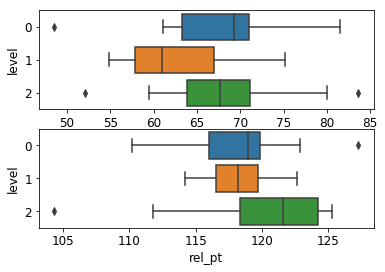

In [179]:
box_plot_post_hoc_index(a_df, v1, show=False, name=n1, dt='amplitude')
# cvis.box_plot_post_hoc_index(a_df, v2, show=False, name=n2, dt='amplitude')
# cvis.box_plot_post_hoc_index(a_df, v3, show=False, name=n3, dt='amplitude')
# cvis.box_plot_post_hoc_index(a_df, v4, show=False, name=n4, dt='amplitude')
# cvis.box_plot_post_hoc_index(a_df, v5, show=False, name=n5, dt='amplitude')
# cvis.box_plot_post_hoc_index(a_df, v6, show=False, name=n6, dt='amplitude')
# cvis.box_plot_post_hoc_index(a_df, v7, show=False, name=n7, dt='amplitude')


### Value

In [150]:
# cvis.box_plot_post_hoc_value(a_df, v1, show=False, name=n1, dt='amplitude')
# cvis.box_plot_post_hoc_value(a_df, v2, show=False, name=n2, dt='amplitude')
# cvis.box_plot_post_hoc_value(a_df, v3, show=False, name=n3, dt='amplitude')
# cvis.box_plot_post_hoc_value(a_df, v4, show=False, name=n4, dt='amplitude')
# cvis.box_plot_post_hoc_value(a_df, v5, show=False, name=n5, dt='amplitude')
# cvis.box_plot_post_hoc_value(a_df, v6, show=False, name=n6, dt='amplitude')
# cvis.box_plot_post_hoc_value(a_df, v7, show=False, name=n7, dt='amplitude')


In [13]:
# vmc7 = v_df.vel_max_c7['index'].dropna()
# vmpel = v_df.vel_max_pel['index'].dropna()
# vmcop = v_df.vel_max_cop['index'].dropna()
# f = plt.figure()
# sns.distplot(vmc7, color='r')
# sns.distplot(vmpel, color='b')
# sns.distplot(vmcop, color='k')
# f.set_size_inches(10,8)
# plt.savefig('displot_vitesse_max_vel.png')

In [14]:
df= a_df
v = 'start_cm'
hue = 'value'
data = cstats.get_data_for_anova(df, v, hue)
results = ols("{} ~ C(level)".format(v), data=data).fit() 
aov_tbl = cstats.anova_table(sm.stats.anova_lm(results, typ=2))        


AttributeError: module 'statsmodels.stats' has no attribute 'anova_lm'

In [15]:
data = data.reset_index()
data.rename(columns={'index':'player'}, inplace=True)
data

,player,start_cm,level
0,player_0,0.000685,0
1,player_1,0.000756,0
2,player_2,0.002141,0
3,player_3,0.002626,0
4,player_4,0.000303,0
5,player_5,0.001176,0
6,player_6,0.002912,0
7,player_7,0.000141,0
8,player_8,0.001799,0
9,player_9,0.001006,0


In [16]:
res2 = sm.stats.anova.AnovaRM(data, 'start_cm', 'player', within=['level'])

In [17]:
print(res2.fit())

               Anova
      Num DF  Den DF F Value Pr > F
-----------------------------------
level 2.0000 18.0000  1.8100 0.1922



In [18]:
print(res2)

In [19]:
amp_aov_value = cstats.create_df_with_all_anova(a_df, hue='value')
amp_aov_index = cstats.create_df_with_all_anova(a_df, hue='index')
vit_aov_value = cstats.create_df_with_all_anova(v_df, hue='value')
vit_aov_index = cstats.create_df_with_all_anova(v_df, hue='index')

In [20]:
amp_aov_index[1]

{'start_cm': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886c24e0>,
 'rel_pt': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886ba3c8>,
 'amp_max_cop': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886cb668>,
 'amp_max_pel': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886c2f60>,
 'amp_max_c7': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886e40b8>,
 'vel_max_cop': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886d9208>,
 'vel_max_pel': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886ed358>,
 'vel_max_c7': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886edcc0>,
 'overshoot': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886f9630>,
 'dcm': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x12d886f9208>,
 'dtml': <statsmodels.regression.linear_model.Regr

## save to excel

In [21]:
fileName = 'anova'
with pd.ExcelWriter('{}.xlsx'.format(fileName)) as writer:
    amp_aov_value[0].to_excel(writer, sheet_name = 'amp_value')
    amp_aov_index[0].to_excel(writer, sheet_name = 'amp_index')
    vit_aov_value[0].to_excel(writer, sheet_name = 'vit_value')
    vit_aov_index[0].to_excel(writer, sheet_name = 'vit_index')

## test residual normality

In [22]:
amp_aov_shapiro_value = cstats.test_anova_shapiro(a_df)
amp_aov_shapiro_index = cstats.test_anova_shapiro(a_df, hue='index')
vit_aov_shapiro_value = cstats.test_anova_shapiro(v_df)
vit_aov_shapiro_index = cstats.test_anova_shapiro(v_df, hue='index')

## save to excel

In [23]:
fileName = 'anova_res_shapiro'
with pd.ExcelWriter('{}.xlsx'.format(fileName)) as writer:
    amp_aov_shapiro_value.to_excel(writer, sheet_name = 'amp_value')
    amp_aov_shapiro_index.to_excel(writer, sheet_name = 'amp_index')
    vit_aov_shapiro_value.to_excel(writer, sheet_name = 'vit_value')
    vit_aov_shapiro_index.to_excel(writer, sheet_name = 'vit_index')


## post hoc tukey hsd

In [24]:
amp_ph_tukeyhsd_value = cstats.create_df_with_all_post_hoc(a_df)
amp_ph_tukeyhsd_index = cstats.create_df_with_all_post_hoc(a_df, hue='index')
vit_ph_tukeyhsd_value = cstats.create_df_with_all_post_hoc(v_df)
vit_ph_tukeyhsd_index = cstats.create_df_with_all_post_hoc(v_df, hue='index')

In [25]:
amp_ph_tukeyhsd_index

group1    group2  meandiff     lower     upper  \
start_cm    comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
rel_pt      comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
amp_max_cop comparaison 0         0         1    11.003   -1.6066   23.6125   
            comparaison 1         0         2   13.8906    1.2811   26.5002   
            comparaison 2         1         2    2.8877   -9.7219   15.4972   
amp_max_pel comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
amp_max_c7  comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
vel_max_cop comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
vel_max_pel comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
vel_max_c7  comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
overshoot   comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
dcm         comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
dtml        comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   
rcm         comparaison 0  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 1  anova ns  anova ns  anova ns  anova ns  anova ns   
            comparaison 2  anova ns  anova ns  anova ns  anova ns  anova ns   

                             reject  
start_cm    comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
rel_pt      comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
amp_max_cop comparaison 0     False  
            comparaison 1      True  
            comparaison 2     False  
amp_max_pel comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
amp_max_c7  comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
vel_max_cop comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
vel_max_pel comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
vel_max_c7  comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
overshoot   comparaison 0  anova ns  
            comparaison 1  anova ns  
            comparaison 2  anova ns  
dcm         comparaison 0  anova ns  
   

### save to excel

In [26]:
fileName = 'anova_poshoc_tukeyhsd'
with pd.ExcelWriter('{}.xlsx'.format(fileName)) as writer:
    amp_ph_tukeyhsd_value.to_excel(writer, sheet_name = 'amp_value')
    amp_ph_tukeyhsd_index.to_excel(writer, sheet_name = 'amp_index')
    vit_ph_tukeyhsd_value.to_excel(writer, sheet_name = 'vit_value')
    vit_ph_tukeyhsd_index.to_excel(writer, sheet_name = 'vit_index')

## skewness residual

In [27]:
amp_res_skew_value = cstats.test_anova_skewness(a_df)
amp_res_skew_index = cstats.test_anova_skewness(a_df, hue='index')
vit_res_skew_value = cstats.test_anova_skewness(v_df)
vit_res_skew_index = cstats.test_anova_skewness(v_df, hue='index')

## save to excel

In [28]:
fileName = 'anova_residual_skewness'
with pd.ExcelWriter('{}.xlsx'.format(fileName)) as writer:
    amp_res_skew_value.to_excel(writer, sheet_name = 'amp_value')
    amp_res_skew_index.to_excel(writer, sheet_name = 'amp_index')
    vit_res_skew_value.to_excel(writer, sheet_name = 'vit_value')
    vit_res_skew_index.to_excel(writer, sheet_name = 'vit_index')

(array([1., 2., 2., 5., 5., 4., 6., 2., 1., 2.]),
 array([48.5       , 52.01333333, 55.52666667, 59.04      , 62.55333333,
        66.06666667, 69.58      , 73.09333333, 76.60666667, 80.12      ,
        83.63333333]),
 <a list of 10 Patch objects>)

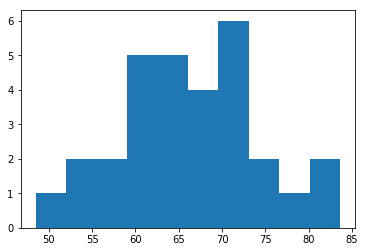

In [29]:
data = cstats.get_data_for_anova(a_df, 'start_cm', 'index')
plt.hist(data['start_cm'])

In [30]:
65/50

1.3

In [31]:
v_df.describe()

start_cm                  rel_pt             amp_max_cop              \
            index       value       index       value       index       value   
count  873.000000  873.000000  873.000000  873.000000  873.000000  873.000000   
mean    65.183276    0.003032  108.918671   -0.026069  157.915235    0.086114   
std     31.544069    0.007907    9.601296    0.015242   21.079571    0.020968   
min     15.000000   -0.023674   29.000000   -0.099596  104.000000    0.011781   
25%     32.000000    0.000185  106.000000   -0.034894  142.000000    0.072809   
50%     79.000000    0.002407  109.000000   -0.023164  157.000000    0.085332   
75%     91.000000    0.005827  112.000000   -0.014739  174.000000    0.100216   
max    151.000000    0.127797  164.000000   -0.000060  205.000000    0.145653   

      amp_max_pel              amp_max_c7              ...  vel_max_c7  \
            index       value       index       value  ...       index   
count  873.000000  873.000000  873.000000  873.000000  ...  873.000000   
mean   171.548683    0.042430  171.197022    0.060726  ...  120.248568   
std     25.295641    0.019056   25.996341    0.028300  ...    9.075187   
min     50.000000   -0.012619   50.000000   -0.021693  ...   41.000000   
25%    156.000000    0.030141  156.000000    0.042896  ...  117.000000   
50%    174.000000    0.043532  171.000000    0.060157  ...  120.000000   
75%    187.000000    0.056379  187.000000    0.079607  ...  123.000000   
max    205.000000    0.091444  205.000000    0.158264  ...  175.000000   

                    overshoot                     dcm                    dtml  \
            value       index       value       index       value       index   
count  873.000000  873.000000  873.000000  873.000000  873.000000  873.000000   
mean     0.000210   82.570447    0.087747   43.735395    0.029101   68.065292   
std      0.000410   11.680372    0.022479   30.370870    0.017569   33.144376   
min     -0.000573   34.000000    0.009719    3.000000    0.000177   15.000000   
25%      0.000016   77.000000    0.073911   18.000000    0.017414   41.000000   
50%      0.000081   84.000000    0.088058   30.000000    0.024819   55.000000   
75%      0.000224   91.000000    0.102310   74.000000    0.036472  102.000000   
max      0.003207   99.000000    0.149919  111.000000    0.173716  152.000000   

                          rcm              
            value       index       value  
count  873.000000  873.000000  873.000000  
mean     0.045475    0.606549    0.736809  
std      0.010424    0.272653    0.980030  
min      0.000258    0.038462    0.021878  
25%      0.039225    0.457143    0.381939  
50%      0.045685    0.594937    0.562187  
75%      0.052563    0.746032    0.816287  
max      0.076446    5.333333   15.432318  

[8 rows x 24 columns]

In [32]:
a=[1,2,3,4]
b = ['a', 'b', 'c', 'd']


In [33]:
for c in zip(a,b):
    print(c)

(1, 'a')
(2, 'b')
(3, 'c')
(4, 'd')


In [34]:
line_plot_3_joints(v_jt_full_df)
line_plot_3_joints(a_jt_full_df, dt='amplitude')

NameError: name 'line_plot_3_joints' is not defined

In [126]:
def line_plot_3_joints(df_full_jt,  M=None, m=None, save=True, name='triple joint plot - {}', dt='vitesse'): 
    from matplotlib.patches import Patch
    
    SMALL_SIZE = 14
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE) 
    
    df = cvis.transform_data_for_lineplot(df_full_jt)
    cop = df[df['data_type']=='cof']
    pelvis = df[df['data_type']=='pelvis']
    c7 = df[df['data_type']=='c7']

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, constrained_layout=True)
    
    if M is None or m is None:
        M = max(cop['value'].max(),pelvis['value'].max(), c7['value'].max())
        m = min(cop['value'].min(),pelvis['value'].min(), c7['value'].min())

    fig.set_size_inches(10, 6.5)
    ax_ = sns.lineplot(x='time', y='value', hue='level',hue_order=['lvl_0', 'lvl_1', 'lvl_2'], ci='sd', data=c7, ax = axes[0], legend='full')
    change_style_jt_dt(ax_, 'r', '-.')
    ax_ = sns.lineplot(x='time', y='value', hue='level', ci='sd', data=pelvis, ax = axes[1], legend='full')
    change_style_jt_dt(ax_, 'b', '--')
    ax_ = sns.lineplot(x='time', y='value', hue='level', ci='sd', data=cop, ax = axes[2], legend='full')
    change_style_jt_dt(ax_, 'k', '-')

    axes[0].set_ylim([m-0.005, M+0.005])
    axes[1].set_ylim([m-0.005, M+0.005])
    axes[2].set_ylim([m-0.005, M+0.005])

    axes[0].set_ylabel('Ms{} (m)'.format(u'\u2096'))
    axes[1].set_ylabel('Sb{} (m)'.format(u'\u2096'))
    axes[2].set_ylabel('CdP (m)')
    
    #defining patch instead of line in legend
    patch_1 = Patch(color='b', alpha = 0.3, edgecolor=None)
    patch_2 = Patch(color='C1', alpha = 0.3, edgecolor=None)
    patch_3 = Patch(color='g', alpha = 0.3, edgecolor=None)
    
    #legend set up 
    """https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot"""
    L = axes[1].legend(handles = [patch_1, patch_2, patch_3], loc='center left', bbox_to_anchor = (1.04, 0.5), fancybox=True, shadow=True, ncol=1, title="Légende")
    L.get_texts()[0].set_text('Niveau 1')
    L.get_texts()[1].set_text('Niveau 2')
    L.get_texts()[2].set_text('Niveau 3')
    
    
    plt.xlabel('Temps (s)')
    plt.xlim([0,400])
    hticks = axes[2].get_xticks()
    hticks = list(str(round((t/50),3)) for t in hticks) #convertir en seconde
    axes[2].set_xticklabels(hticks)
    
    #adding title 
#     plt.suptitle('Dynamique du tML dans la condition {}'.format(dt), y=1.01)
    """from : https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny"""
#     title_text='Dynamique du tML dans la condition {}'.format(dt)
#     axes[0].text(0.5, 1.08, title_text,
#          horizontalalignment='center',
#          fontsize=20,
#          transform = axes[0].transAxes)
    plt.tight_layout()

    
    if save:
        cwd = os.getcwd().replace('\\', '/')
        png_name = cwd + '/graphique_cine/{}/{}.png'.format(dt, name)
        plt.savefig(png_name, dpi=1000)

In [119]:
def line_plot_2_angle(df_full_angle, save=True, name='angle plot - {}', dt='vitesse'): 
    df = cvis.transform_data_for_lineplot(df_full_angle)
    teta1 = df[df['data_type']=='teta1']
    teta2 = df[df['data_type']=='teta2']

    
    fig, ax = plt.subplots(nrows=1, ncols=1 )
    M = max(teta1['value'].max(), teta2['value'].max())
    m = min(teta1['value'].min(), teta2['value'].min())

    fig.set_size_inches(18.5, 10)
    ax = sns.lineplot(x='time', y='value', hue='level', ci = 'sd', style = 'data_type', data = df, ax=ax)
    change_style(ax)
    ax.set_ylim([m-0.005, M+0.005])

    ax.set_ylabel('degrée')

    plt.xlabel('Temps (s)')

    hticks = ax.get_xticks()
    hticks = list(str(round((t/50),3))[:5] for t in hticks) #convertir en seconde
    ax.set_xticklabels(hticks)
    plt.xlim([0,400])
    
    plt.suptitle('Cinématique des angles de la condition {}'.format(dt), fontsize=26, y=1.02)
    
    plt.tight_layout()

    
    if save:
        cwd = os.getcwd().replace('\\', '/')
        png_name = cwd + '/graphique_cine/{}/{}.png'.format(dt, name)
        plt.savefig(png_name, dpi=1000)
        

In [120]:
def get_min_max_kin(jt_full_df):
    df = cvis.transform_data_for_lineplot(jt_full_df)
    cop = df[df['data_type']=='cof']
    pelvis = df[df['data_type']=='pelvis']
    c7 = df[df['data_type']=='c7']

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    M = max(cop['value'].max(),pelvis['value'].max(), c7['value'].max())
    m = min(cop['value'].min(),pelvis['value'].min(), c7['value'].min())
    return M, m

In [121]:
df_full_jt = a_jt_full_df
df = cvis.transform_data_for_lineplot(df_full_jt)
cop = df[df['data_type']=='cof']
pelvis = df[df['data_type']=='pelvis']
c7 = df[df['data_type']=='c7']

(1289, 2700)
(1289, 2700)
(1289, 2700)


In [122]:
df.head()

,time,players,level,data_type,value
0,0,player_0,lvl_0,cof,-0.001095
1,1,player_0,lvl_0,cof,-0.001046
2,2,player_0,lvl_0,cof,-0.001008
3,3,player_0,lvl_0,cof,-0.000983
4,4,player_0,lvl_0,cof,-0.000971


(1361, 2700)
(1361, 2700)
(1361, 2700)
(1289, 2700)
(1289, 2700)
(1289, 2700)
(1289, 2700)
(1289, 2700)
(1289, 2700)


C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\matplotlib\figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


(1361, 2700)
(1361, 2700)
(1361, 2700)


C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\matplotlib\figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


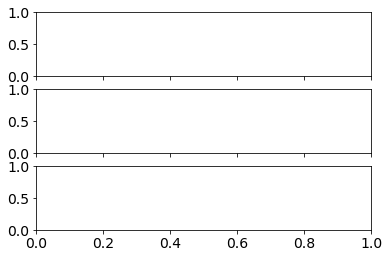

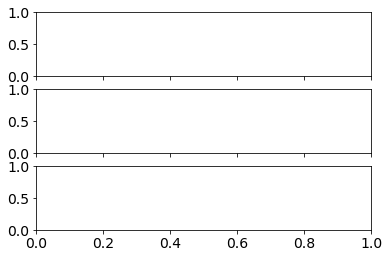

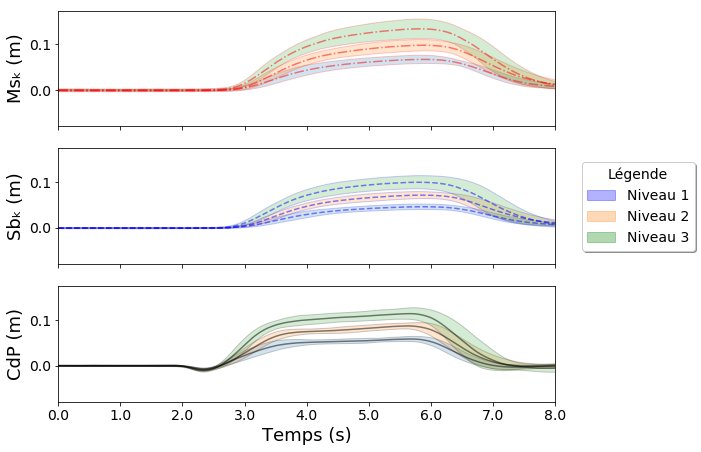

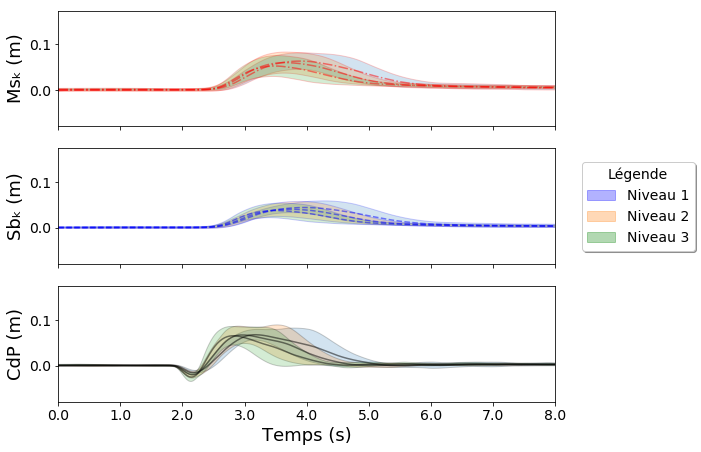

In [127]:
M_v,m_v = get_min_max_kin(v_jt_full_df)
M_a,m_a = get_min_max_kin(a_jt_full_df)
M = max(M_v,M_a)
m = min(m_v,m_a)
line_plot_3_joints(a_jt_full_df, M=M, m=m, dt='amplitude', save=True)
line_plot_3_joints(v_jt_full_df, M=M, m=m, save=True)


(225, 2700)
(225, 2700)
(225, 2700)


TypeError: change_style_jt_dt() missing 1 required positional argument: 'lsty'

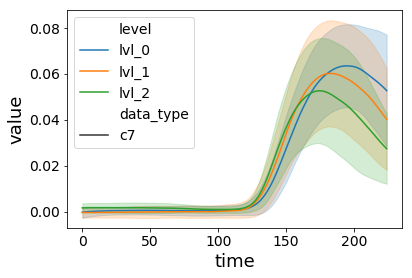

In [23]:
df = cvis.transform_data_for_lineplot(v_jt_full_df[:225])
c7 = df[df['data_type']=='c7']

ax = sns.lineplot(x='time', y='value', hue='level', ci='sd', style = 'data_type', data=c7)
change_style_jt_dt(ax, 'r')



In [38]:
for c in ax.get_children():
    print(c)

NameError: name 'ax' is not defined

In [39]:
p.set_color

NameError: name 'p' is not defined

In [12]:
def change_style_all_jt(ax):
    poly, line2D = ax.get_children()[:9], ax.get_children()[9:18] 
    poly_cof = list((poly[0], poly[3], poly[6]))
    poly_pel = list((poly[1], poly[4], poly[7]))
    poly_c7 = list((poly[2], poly[5], poly[8]))
    
    line_cof = list((line2D[0], line2D[3], line2D[6]))
    line_pel = list((line2D[1], line2D[4], line2D[7]))
    line_c7 = list((line2D[2], line2D[5], line2D[8]))
    
    for p in poly_cof:
        p.set_edgecolor('k')
    for l in line_cof:
        l.set_color('k')
        
    for p in poly_pel:
        p.set_edgecolor('b')
    for l in line_pel:
        l.set_color('b')
    
    for p in poly_c7:
        p.set_edgecolor('r')
    for l in line_c7:
        l.set_color('r')

In [13]:
def change_style_jt_dt(ax, c, lsty, legend=False):
    poly, line2D = ax.get_children()[:3], ax.get_children()[3:6] 
    poly_lvl = list((poly[0], poly[1], poly[2]))
    line_lvl = list((line2D[0], line2D[1], line2D[2]))
    
    
    for p in poly_lvl:
        p.set_edgecolor(c)
    for l in line_lvl:
        l.set_color(c)
        l.set_alpha(0.5)
        l.set_linestyle(lsty)
    if not legend:
        ax.legend_.remove()
 

In [14]:
def change_style_angle_dt(ax, c):
    poly, line2D = ax.get_children()[:3], ax.get_children()[3:6] 
    poly_teta1 = list((poly[0], poly[1], poly[2]))
    line_lvl = list((line2D[3], line2D[4], line2D[5]))
    
    
    for p in poly_lvl:
        p.set_edgecolor(c)
    for l in line_lvl:
        l.set_color(c)
 